In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of dataloader failed: Traceback (most recent call last):
  File "/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: __class__ assignment: 'DiabetesDataset' object layout di

In [261]:
import os
import sys

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import dataloader
import modules 
import plots
from trainer import Trainer
import torch 
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import utilities
import numpy as np
from IPython.display import display, Markdown

## Load in the data

See `dataloader.py` for implementation details.

In [49]:
diabetes_dataset = dataloader.DiabetesDataset(batch_size=32)

In [50]:
test_batch = next(iter(diabetes_dataset.get_dataloader(train=True)))
print(test_batch[0].shape)
print(test_batch[1].shape)

torch.Size([32, 10])
torch.Size([32, 1])


## Initialise a model

In this implementation, we can specify limited variations on our existing model architecture by passing in a list of integers specifying the shapes of the hidden layers we desire. These will be linear fully connected layers with ReLU activation and a single output node. For example:

```
network_architecture = [50, 50]
model = modules.LinearReLUMLP(network_architecture)

print(model.net)

>>>

ModuleList(
  (0): LazyLinear(in_features=0, out_features=50, bias=True)
  (1): ReLU()
  (2): LazyLinear(in_features=0, out_features=50, bias=True)
  (3): ReLU()
  (4): LazyLinear(in_features=0, out_features=1, bias=True)
)
```

In [254]:
# [16. 4], learning_rate=0.00015, weight_decay=0.05

# network_architecture = [16]
# model = modules.LinearReLUMLP(network_architecture, learning_rate=0.0005, weight_decay=0.035)

#  a
network_architecture = [16]
model = modules.LinearReLUMLP(network_architecture, learning_rate=0.0005, weight_decay=0.035)
model.apply_initialization(torch.randn(1, len(diabetes_dataset.feature_names)))

/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [255]:
print(model.net)

Sequential(
  (0): Linear(in_features=10, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=1, bias=True)
)


## Initialise a trainer

The trainer combines our data and model and facilitates the actual training loop.

In [256]:
trainer = Trainer(max_epochs=65, init_random=32)
trainer.fit(model, diabetes_dataset)

Model running on cpu
Epoch 65/65: Train Loss: 2950.6174, Val Loss: 3245.43380


Text(0, 0.5, 'Predicted Disease Progression')

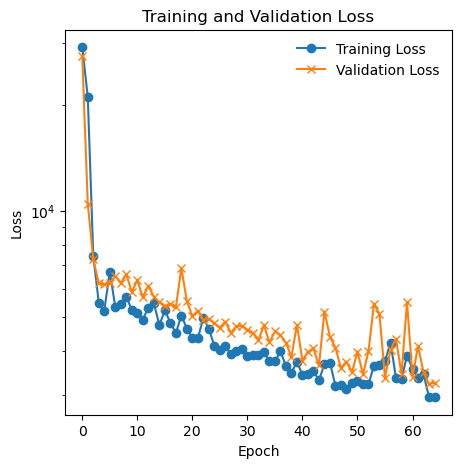

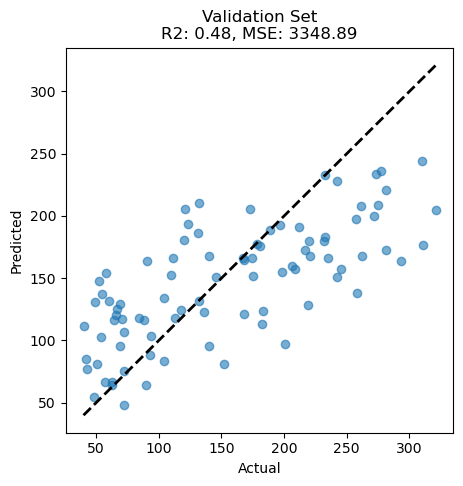

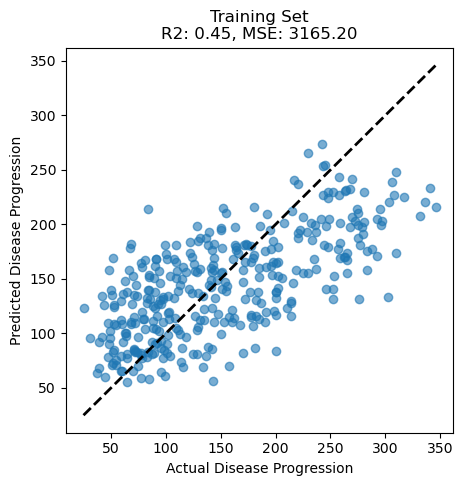

In [257]:
losses = utilities.extract_training_losses(trainer.metadata)
fig, ax = plots.plot_training_validation_loss(losses['avg_train_losses'], losses['avg_val_losses'])
ax.set_yscale("log")


y_val, y_hat_val = utilities.get_model_predictions(model, diabetes_dataset, train=False)
y_train, y_hat_train = utilities.get_model_predictions(model, diabetes_dataset, train=True)
fig, ax = plots.correlate_y_vs_yhat(y_val, y_hat_val, title="Validation Set")
fig, ax = plots.correlate_y_vs_yhat(y_train, y_hat_train, title="Training Set")
ax.set_xlabel("Actual Disease Progression")
ax.set_ylabel("Predicted Disease Progression")

In [259]:
k = 5
k_fold_datasets = []
k_fold_models = []
trainers = []

for n in range(k):
    model = modules.LinearReLUMLP(network_architecture, learning_rate=0.006, weight_decay=0.1)
    data = dataloader.KFoldDataSet.from_dataset(dataset=diabetes_dataset, k=k, n=n)

    trainer = Trainer(max_epochs=25, init_random=42)
    trainer.fit(model, data)

    k_fold_datasets.append(data)
    k_fold_models.append(model)
    trainers.append(trainer)

    

/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Model running on cpu
Epoch 25/25: Train Loss: 4429.2690, Val Loss: 3226.78884
Model running on cpu
Epoch 25/25: Train Loss: 5417.3574, Val Loss: 4667.51269
Model running on cpu
Epoch 25/25: Train Loss: 4371.2424, Val Loss: 3594.88221
Model running on cpu
Epoch 25/25: Train Loss: 5649.1627, Val Loss: 7224.539734
Model running on cpu
Epoch 25/25: Train Loss: 6237.1244, Val Loss: 4658.71224


## Model Trained on cross-validation set 1/5

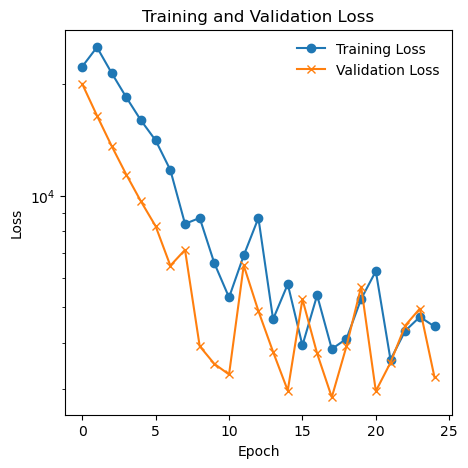

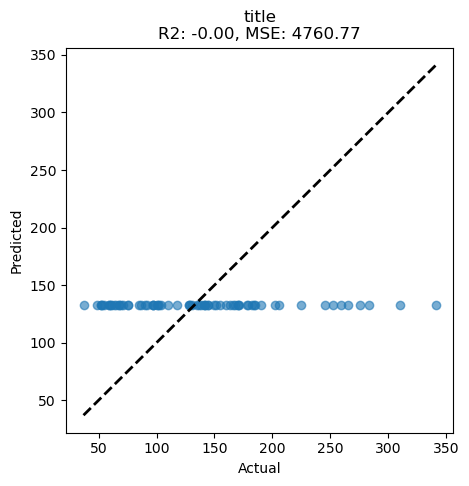

## Model Trained on cross-validation set 2/5

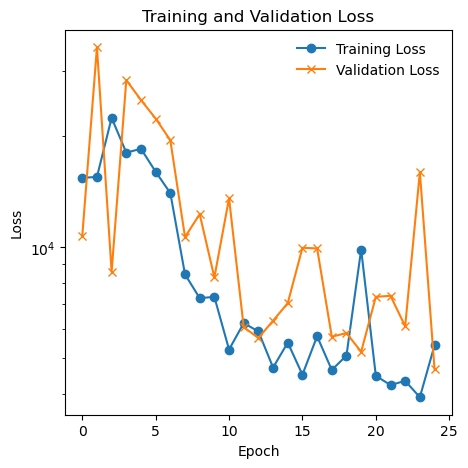

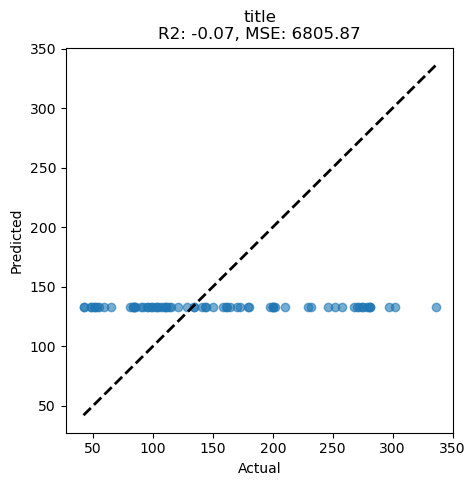

## Model Trained on cross-validation set 3/5

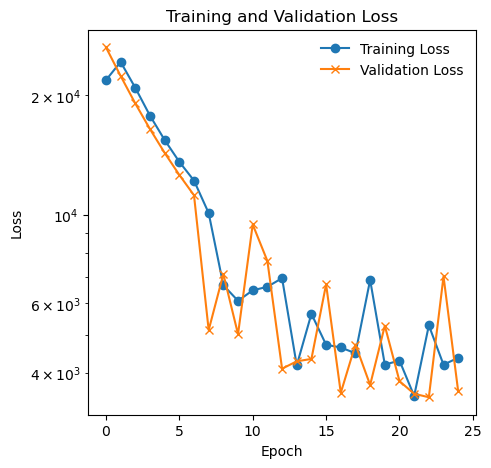

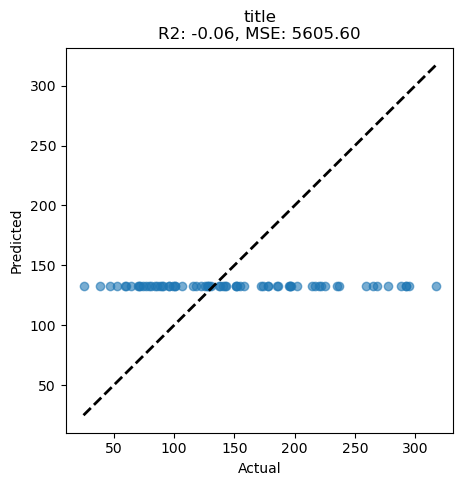

## Model Trained on cross-validation set 4/5

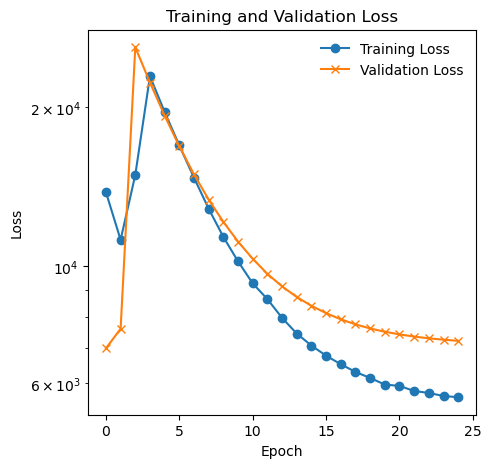

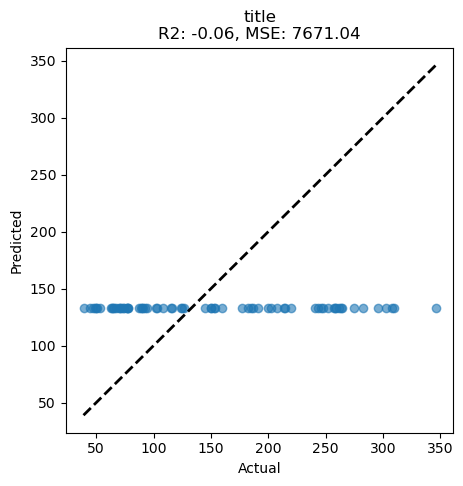

## Model Trained on cross-validation set 5/5

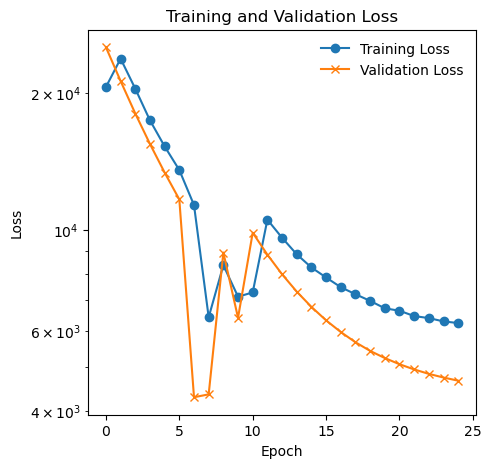

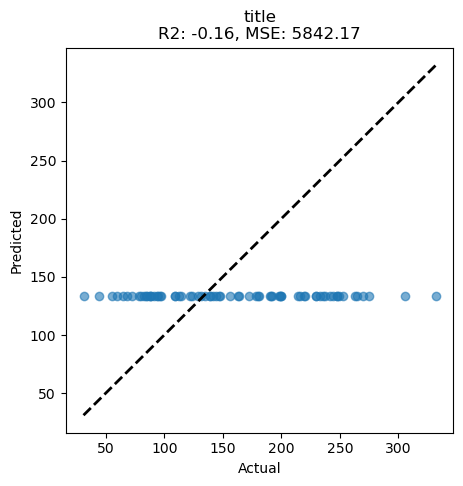

In [263]:
for i, trainer in enumerate(trainers):
    display(Markdown(f"## Model Trained on cross-validation set {i+1}/{k}"))

    losses = utilities.extract_training_losses(trainer.metadata)
    fig, ax = plots.plot_training_validation_loss(losses['avg_train_losses'], losses['avg_val_losses'])
    ax.set_yscale("log")
    y, y_hat = utilities.get_model_predictions(model, k_fold_datasets[i], train=False)
    fig, ax = plots.correlate_y_vs_yhat(y, y_hat, title="title")
    # ax.set_xlabel("Actual Price (USD)")
    # ax.set_ylabel("Predicted Price (USD)")
    plt.show()